We implement the speeding up at no job left behind in the completely online version of the policy, and see if it matches our heuristic.

In [1]:
%matplotlib inline
from pylab import *
import sys
from collections import namedtuple
import random
import time
import numpy as np

In [2]:
def log_normal(mu=0, sigma=1):
    return e**(mu+sigma*np.random.normal())

def exp_samples(lambd=1,n=1):
    """
    generates a numpy array of n samples distributed according to
    an exponential distribution with parameter λ
    """
    random.seed(time.time())
    return (-1/lambd)*log(rand(n))

def exp(lambd=1):
    """
    generates a sample distributed according to
    an exponential distribution with parameter λ
    """
    if lambd < 0:
        return inf()
    random.seed(time.time())
    return (-1/lambd)*log(rand())

def inf():
    return 999999


def printarray(a): 
    print(np.around(a, 3))
    

In [3]:
def gen_interarrivals_and_services(lambd, mu1, n):
    return exp_samples(lambd, n), exp_samples(mu1, n)

In [40]:
lambd = 0.999
mu1 = 0.9
n = 1000

In [52]:
interarrivals, services = gen_interarrivals_and_services(lambd, mu1, n)

arrival_times = []
for i in range(len(interarrivals)):
    arrival_times.append(sum(interarrivals[0:i + 1]))
#print(arrival_times)

service_times = [arrival_times[0] + services[0]]
for i in range(1, len(services)):
    service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
#print(service_times)

In [53]:
def generate_T_N(interarrivals, services):
    T = [0]
    N = [0]

    arrival_index = 0
    service_index = 0
  
    arrival_times = []
    for i in range(len(interarrivals)):
        arrival_times.append(sum(interarrivals[0:i + 1]))
    #print(arrival_times)

    service_times = [arrival_times[0] + services[0]]
    for i in range(1, len(services)):
        service_times.append(max(arrival_times[i], service_times[i - 1]) + services[i])
    #print(service_times)

    next_arrival = arrival_times[arrival_index]
    next_service = service_times[service_index]

    while min(next_arrival, next_service) != inf():
        if next_arrival < next_service:
            N.append(N[-1] + 1)
            T.append(next_arrival)
            arrival_index += 1
            if arrival_index == len(arrival_times):
                next_arrival = inf()
            else:
                next_arrival = arrival_times[arrival_index]
        else:
            N.append(N[-1] - 1)
            T.append(next_service)
            service_index += 1
            if service_index == len(service_times):
                next_service = inf()
            else:
                next_service = service_times[service_index]

    return T, N

In [57]:
def implement_speedup(interarrivals, services):
    w = np.zeros(n) # waiting time array
    index = 0
    
    # Counting the proportion of jobs we speed up, can be no more than g
    speed_up_num = 0
    speed_up_denom = 0
    
    # Indicies for counting surge
    start = int(0.1 * n)
    end = int(0.9 * n)

    for index in range(n - 1):
        for i in range(index, n - 1):
            w[i + 1] = max(w[i] + services[i] - interarrivals[i], 0)
            if w[i + 1] <= 0:
                #print("Not speeding up job at T=%.2f" % (arrival_times[index]))
                break
            if i == n - 2:
                services[index] = (mu1) * services[index]
                if index >= start and index <= end:
                    speed_up_num += 1
                #print("Speeding up job at T=%.2f" % (arrival_times[index]))
        if index >= start and index <= end:
            speed_up_denom += 1

        w[index + 1] = max(w[index] + services[index] - interarrivals[index], 0)
    
    print("Expected waiting time %.2f" % (np.mean(w[start:end])))
    print("Speed up for %.2f proportion of time" % (speed_up_num / speed_up_denom))
    T2, N2 = generate_T_N(interarrivals, services)
    return T2, N2, w, speed_up_num / speed_up_denom

Expected waiting time 26.14
Speed up for 0.86 proportion of time
1000
2001


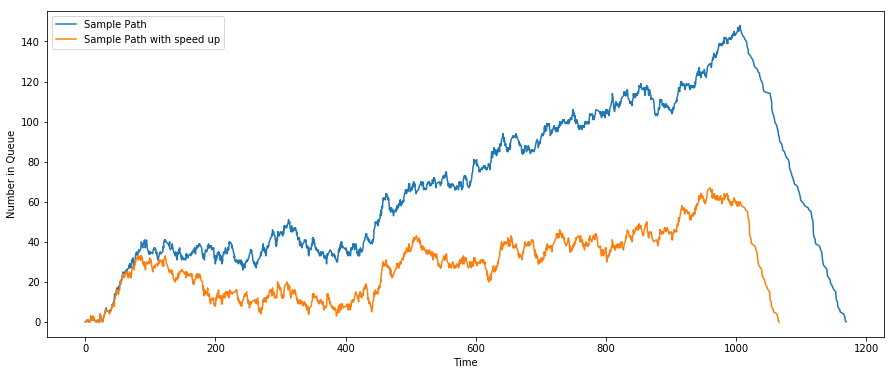

In [58]:
T, N = generate_T_N(interarrivals.copy(), services.copy())
T2, N2, w, _ = implement_speedup(interarrivals.copy(), services.copy())
print(len(w))
print(len(N2))
figure(figsize=(15,6))
plot(T, N, label='Sample Path')
plot(T2, N2, label='Sample Path with speed up')
xlabel('Time')
ylabel('Number in Queue')
legend()

In [10]:
# Implement no policy (always use slow service time) on an array of arrivals.
# Returns T, N, D, waiting times. Proportion of surge is always 0.
def MM1Normal(arrivals, c, Tmax):
    T             = [0]  # list of times that events occur in real time
    N             = [0]  # initial state of the system
    D             = [0]  # arrivals and departures list
    
    # customers currently being served by a server
    servers = []
    
    # customers that are waiting to be served by a server
    queue = []
    
    # times spent by users inside the system
    waiting_times = []
    
    # arrival index represents when we either add to queue or to server if it's free
    arrival_index = 0
    arrivals_len = len(arrivals) - 1
    
    # first event must be an arrival
    next_arrival = arrivals[arrival_index].arrival_time
    next_departure = inf()
    
    while T[-1] < Tmax:
        T.append(min(next_arrival, next_departure))
        
        ##### ARRIVAL ##### 
        if T[-1] == next_arrival:
            N.append(N[-1] + 1) 
            D.append(1)
            arrival = arrivals[arrival_index]
            arrival_index += 1
            if len(servers) < c:
                servers.append(wcustomer_with_parameters(arrival, T[-1], False))
            else:
                queue.append(arrival)
                
        ##### DEPARTURE #####     
        elif T[-1] == next_departure:
            N.append(N[-1] - 1)
            D.append(-1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)
            # put the next person from the queue into the server
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(wcustomer_with_parameters(next_to_enter, T[-1], False))
        
        if arrival_index < len(arrivals):
            next_arrival = arrivals[arrival_index].arrival_time
        else:
            next_arrival = inf()
        
        if len(servers) > 0:
            next_departure = servers[0].service_time
        else:
            next_departure = inf()
        
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    D = D[1:]
    return T, N, D, waiting_times

In [11]:
# ##### NO JOB LEFT BEHIND POLICY ########

def MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    
    
    # customers currently being served by a server
    servers = [customer(0) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(0) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        event_rate = lambd + mu1*(0 < N[-1] and N[-1] < surge_threshold) + mu2*(surge_threshold <= N[-1])
        next_event = exp(event_rate)
        T.append(t_temp + next_event)
        event = rand()
            
        ##### ARRIVAL ##### 
        if event < lambd / event_rate:
            N.append(N[-1] + 1) 
            if len(servers) < c:
                servers.append(customer(T[-1]))
            else:
                queue.append(customer(T[-1]))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(customer(next_to_enter.arrival_time))
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta

    S = S / (T[-1] - start_measuring_surge)
    in_surge = in_surge / (T[-1] - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

In [12]:
# ##### THRESHOLD POLICY ########

def MM1WithOneThreshold(lambd, mu1, mu2, surge_threshold, c, N0, Tmax):
    T             = [0]  # list of times that events occur
    t_temp        = 0    # temporary time to calculate delta
    N             = [N0] # initial state of the system
    S             = 0    # area under curve starting with T=1000
    in_surge      = 0    # time spent in surge
    start_measuring_surge = 0
    
    
    # customers currently being served by a server
    servers = [customer(0) for _ in range(min(c, N0))]
    
    # customers that are waiting to be served by a server
    queue = [customer(0) for _ in range(N0 - c)]
    
    # times spent by users inside the system
    waiting_times = []
    
    while T[-1] < Tmax:
        t_temp = T[-1]
        event_rate = lambd + mu1*(0 < N[-1] and N[-1] < surge_threshold) + mu2*(surge_threshold <= N[-1])
        next_event = exp(event_rate)
        T.append(t_temp + next_event)
        event = rand()
            
        ##### ARRIVAL ##### 
        if event < lambd / event_rate:
            N.append(N[-1] + 1) 
            if len(servers) < c:
                servers.append(customer(T[-1]))
            else:
                queue.append(customer(T[-1]))
        ##### DEPARTURE #####     
        else:
            N.append(N[-1] - 1)
            popped_customer = servers.pop(0)
            T_in = popped_customer.arrival_time
            if T_in>0:
                waiting_times.append(T[-1] - T_in)            
            if len(queue) > 0:
                next_to_enter = queue.pop(0)
                servers.append(customer(next_to_enter.arrival_time))
        
        ##### SURGE count and proportion #####
        if T[-1] > 1000:
            if in_surge == 0 and S == 0: # first time, mark t_temp
                start_measuring_surge = T[-2]
            t_delta = T[-1] - T[-2]
            S = S + (t_delta * N[-2])
            if N[-2] >= surge_threshold:
                in_surge = in_surge + t_delta

    S = S / (T[-1] - start_measuring_surge)
    in_surge = in_surge / (T[-1] - start_measuring_surge)
    # discard Tmax
    T = T[:-1] 
    N = N[:-1]
    return T, N, waiting_times, S, in_surge

In [13]:
def min_threshold(lambd, mu1, mu2, g):
    rho1 = lambd / mu1
    rho2 = lambd / mu2
    return math.ceil(math.log((g*(1-rho2)*rho1) / ((1-rho1)*rho2 - g*(rho2 - rho1)), rho1))

def min_g(lambd, mu1, mu2):
    rho1 = lambd / mu1
    rho2 = lambd / mu2
    return (rho1*rho2 - rho2) / (rho1 - rho2)

In [49]:
# lambd is between 1-k and 1-k+gk

k = 0.1
lambd = 0.95
mu1 = 1 - k
mu2 = 1
c = 1
N0 = 0
Tmax = 10000

print("Minimum g needed for this problem is: %.3f" % (min_g(lambd, mu1, mu2)))

gs = [0.55, 0.6, 0.7, 0.8, 0.9]

for g in gs:
    L = min_threshold(lambd, mu1, mu2, g)
    print("Threshold generated by formula for g=%.2f is %d" % (g, L))
    p_surges = list()
    for _ in range(20):
        _, _, _, _, p_in_surge = MM1WithOneThreshold(lambd, mu1, mu2, L, c, N0, Tmax)
        p_surges.append(p_in_surge)
    print("Simulation p mean %.3f std %.3f over 20 trials; g %.2f" % (np.mean(p_surges), np.std(p_surges), g))

Minimum g needed for this problem is: 0.500
Threshold generated by formula for g=0.55 is 32
Simulation p mean 0.537 std 0.100 over 20 trials; g 0.55
Threshold generated by formula for g=0.60 is 21
Simulation p mean 0.575 std 0.092 over 20 trials; g 0.60
Threshold generated by formula for g=0.70 is 11
Simulation p mean 0.697 std 0.082 over 20 trials; g 0.70
Threshold generated by formula for g=0.80 is 6
Simulation p mean 0.786 std 0.043 over 20 trials; g 0.80
Threshold generated by formula for g=0.90 is 3
Simulation p mean 0.869 std 0.035 over 20 trials; g 0.90


In [52]:
# lambd is between 1-k and 1-k+gk

k = 0.2
lambd = 0.91
mu1 = 1 - k
mu2 = 1
c = 1
N0 = 0
Tmax = 10000

print("Minimum g needed for this problem is: %.3f" % (min_g(lambd, mu1, mu2)))

gs = [0.56, 0.6, 0.7, 0.8]

for g in gs:
    L = min_threshold(lambd, mu1, mu2, g)
    print("Threshold generated by formula for g=%.2f is %d" % (g, L))
    p_surges = list()
    for _ in range(20):
        _, _, _, _, p_in_surge = MM1WithOneThreshold(lambd, mu1, mu2, L, c, N0, Tmax)
        p_surges.append(p_in_surge)
    print("Simulation p mean %.3f std %.3f over 20 trials; g %.2f" % (np.mean(p_surges), np.std(p_surges), g))

Minimum g needed for this problem is: 0.550
Threshold generated by formula for g=0.56 is 26
Simulation p mean 0.534 std 0.067 over 20 trials; g 0.56
Threshold generated by formula for g=0.60 is 14
Simulation p mean 0.608 std 0.069 over 20 trials; g 0.60
Threshold generated by formula for g=0.70 is 6
Simulation p mean 0.688 std 0.044 over 20 trials; g 0.70
Threshold generated by formula for g=0.80 is 3
Simulation p mean 0.787 std 0.031 over 20 trials; g 0.80


In [54]:
# lambd is between 1-k and 1-k+gk

k = 0.2
lambd = 0.85
mu1 = 1 - k
mu2 = 1
c = 1
N0 = 0
Tmax = 10000

print("Minimum g needed for this problem is: %.3f" % (min_g(lambd, mu1, mu2)))

gs = [0.26, 0.3, 0.4, 0.5]

for g in gs:
    L = min_threshold(lambd, mu1, mu2, g)
    print("Threshold generated by formula for g=%.2f is %d" % (g, L))
    p_surges = list()
    for _ in range(20):
        _, _, _, _, p_in_surge = MM1WithOneThreshold(lambd, mu1, mu2, L, c, N0, Tmax)
        p_surges.append(p_in_surge)
    print("Simulation p mean %.3f std %.3f over 20 trials; g %.2f" % (np.mean(p_surges), np.std(p_surges), g))

Minimum g needed for this problem is: 0.250
Threshold generated by formula for g=0.26 is 49
Simulation p mean 0.253 std 0.051 over 20 trials; g 0.26
Threshold generated by formula for g=0.30 is 25
Simulation p mean 0.307 std 0.048 over 20 trials; g 0.30
Threshold generated by formula for g=0.40 is 12
Simulation p mean 0.384 std 0.052 over 20 trials; g 0.40
Threshold generated by formula for g=0.50 is 7
Simulation p mean 0.478 std 0.036 over 20 trials; g 0.50


In [20]:
# lambd is between 1-k and 1-k+gk

g = 0.5
k = 0.2
lambds = [0.805, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.865, 0.87, 0.875, 0.88, 0.885, 0.89, 0.8925, 0.895, 0.8975]
mu1 = 1 - k
mu2 = 1
c = 1
N0 = 0
Tmax = 10000

in_surges = list()
Ss = list()
Ls = list()
for lambd in lambds:
    L = min_threshold(lambd, mu1, mu2, g)
    print("Threshold generated by formula for lambd=%.2f is %d" % (lambd, L))
    _, _, _, S, p_in_surge = MM1WithOneThreshold(lambd, mu1, mu2, L, c, N0, Tmax)
    in_surges.append(p_in_surge)
    Ss.append(S)
    Ls.append(L)
print(Ls)
print(Ss)
print(in_surges)

Threshold generated by formula for lambd=0.81 is 5
Threshold generated by formula for lambd=0.81 is 5
Threshold generated by formula for lambd=0.82 is 5
Threshold generated by formula for lambd=0.83 is 6
Threshold generated by formula for lambd=0.84 is 6
Threshold generated by formula for lambd=0.85 is 7
Threshold generated by formula for lambd=0.86 is 8
Threshold generated by formula for lambd=0.86 is 9
Threshold generated by formula for lambd=0.87 is 10
Threshold generated by formula for lambd=0.88 is 11
Threshold generated by formula for lambd=0.88 is 12
Threshold generated by formula for lambd=0.89 is 14
Threshold generated by formula for lambd=0.89 is 16
Threshold generated by formula for lambd=0.89 is 18
Threshold generated by formula for lambd=0.90 is 21
Threshold generated by formula for lambd=0.90 is 27
[5, 5, 5, 6, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 21, 27]
[5.059271370772255, 5.233055675426475, 5.740727759208978, 6.06902434079655, 7.707175175531044, 8.026899964158469, 8.917

Text(0.5,1,'Expected Queue Length vs lambda for g=0.50, k=0.20')

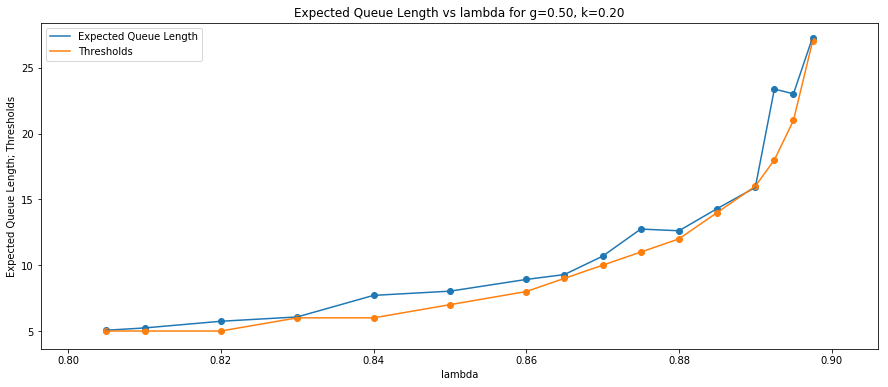

In [24]:
figure(figsize=(15,6))
scatter(lambds, Ss)
scatter(lambds, Ls)
plot(lambds, Ss, label='Expected Queue Length')
plot(lambds, Ls, label='Thresholds')
xlabel('lambda')
ylabel('Expected Queue Length; Thresholds')
legend()
title('Expected Queue Length vs lambda for g=%.2f, k=%.2f' % (g, k))

Text(0.5,1,'p(in surge) vs thresholds for g=0.50, k=0.20')

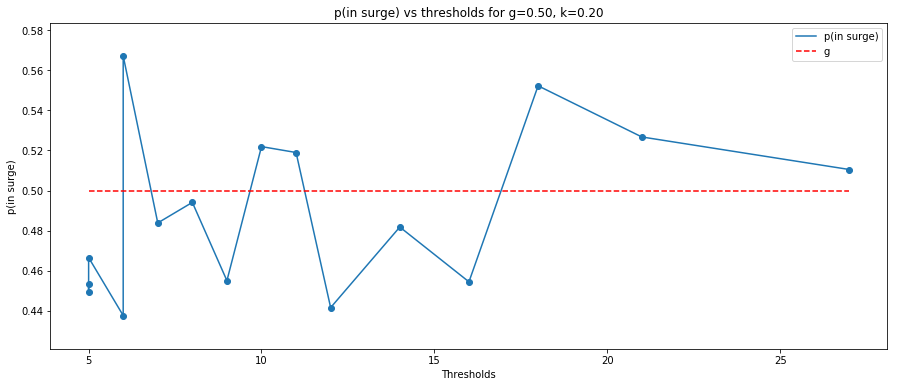

In [28]:
figure(figsize=(15,6))
scatter(Ls, in_surges)
plot(Ls, in_surges, label='p(in surge)')
horiz_line_data = np.array([g for i in range(len(Ls))])
plt.plot(Ls, horiz_line_data, 'r--', label='g') 
xlabel('Thresholds')
ylabel('p(in surge)')
legend()
title('p(in surge) vs thresholds for g=%.2f, k=%.2f' % (g, k))

Text(0.5,1,'p(in surge) vs thresholds for g=0.50, k=0.20')

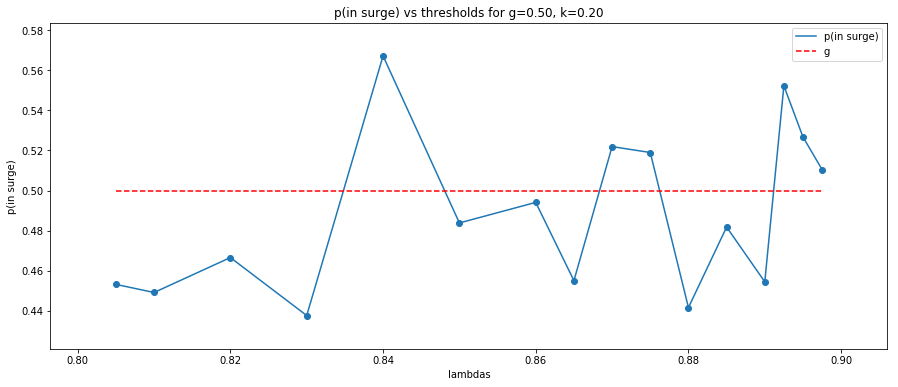

In [29]:
figure(figsize=(15,6))
scatter(lambds, in_surges)
plot(lambds, in_surges, label='p(in surge)')
horiz_line_data = np.array([g for i in range(len(Ls))])
plt.plot(lambds, horiz_line_data, 'r--', label='g') 
xlabel('lambdas')
ylabel('p(in surge)')
legend()
title('p(in surge) vs thresholds for g=%.2f, k=%.2f' % (g, k))

In [ ]:
'''##### SURGE count and proportion #####
            if T[-1] >= 1000 and T[-1] <= 9000:
                if in_surge == 0 and S == 0: # first time, mark t_temp
                    start_measuring_surge = T[-2]
                t_delta = T[-1] - popped_customer.enter_service_time
                S = S + (t_delta * N[-2])
                if popped_customer.fast:
                    in_surge = in_surge + t_delta
            if T[-1] > 9000:
                if end_measuring_surge == 0:
                    end_measuring_surge = T[-1]'''